In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    
    for filename in filenames:
        os.path.join(dirname, filename)

/kaggle/input
/kaggle/input/chess-pieces-detection-images-dataset
/kaggle/input/chess-pieces-detection-images-dataset/Rook-resize
/kaggle/input/chess-pieces-detection-images-dataset/pawn_resized
/kaggle/input/chess-pieces-detection-images-dataset/knight-resize
/kaggle/input/chess-pieces-detection-images-dataset/Queen-Resized
/kaggle/input/chess-pieces-detection-images-dataset/bishop_resized


In [3]:
def datagen_generator():
    datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        height_shift_range=0.5,
        validation_split=0.2
    )
    
    train = datagen.flow_from_directory(
        '/kaggle/input/chess-pieces-detection-images-dataset',
        target_size=(128, 128),
        class_mode='categorical',
        color_mode='grayscale',
        batch_size=32,
        shuffle=True,
        subset='training'
    )
    
    validation = datagen.flow_from_directory(
        '/kaggle/input/chess-pieces-detection-images-dataset',
        target_size=(128, 128),
        class_mode='categorical',
        color_mode='grayscale',
        batch_size=32,
        shuffle=True,
        subset='validation'
    )
    
    return train, validation

train, val = datagen_generator()

Found 523 images belonging to 5 classes.
Found 128 images belonging to 5 classes.


In [4]:
def checkpoint_dir():
    checkpoint_dir = 'checkpoints/'
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
        
    return checkpoint_dir

def checkpoint_path():
    
    return os.path.join(checkpoint_dir(), 'model_checkpoint')

def checkpoint_saver():
    checkpoint = tf.compat.v1.train.Saver()
    checkpoint_dir_ = checkpoint_dir()
    checkpoint_path_ = checkpoint_path()
    
    return checkpoint

In [5]:
def chess_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(1024, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(2048, kernel_size=(3, 5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=2048, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=5, activation='softmax')
    ])
    
    checkpoint_path_ = checkpoint_path()
    
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path_,
        save_weights_only=False,
        monitor='loss',
        mode='min',
        save_best_only=True
    )
    
    callbacks = [
        EarlyStopping(patience=10),
        model_checkpoint_callback
    ]
    
    return model, callbacks

model, callbacks = chess_model()

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       2

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [8]:
history = model.fit(
    train,
    steps_per_epoch=train.samples//32,
    validation_data=val,
    validation_steps=val.samples//32,
    epochs=124,
    #callbacks=callbacks
)

Epoch 1/124


2023-04-25 09:24:46.142343: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


16/16 [==============================] - 18s 383ms/step - loss: 9.7637 - accuracy: 0.2098 - val_loss: 4.6462 - val_accuracy: 0.2656
Epoch 2/124
16/16 [==============================] - 2s 141ms/step - loss: 2.7303 - accuracy: 0.2424 - val_loss: 12.6340 - val_accuracy: 0.2109
Epoch 3/124
16/16 [==============================] - 2s 143ms/step - loss: 2.6134 - accuracy: 0.2383 - val_loss: 5.0603 - val_accuracy: 0.2109
Epoch 4/124
16/16 [==============================] - 2s 139ms/step - loss: 2.1306 - accuracy: 0.2598 - val_loss: 5.6332 - val_accuracy: 0.1328
Epoch 5/124
16/16 [==============================] - 2s 136ms/step - loss: 2.0044 - accuracy: 0.2240 - val_loss: 7.9681 - val_accuracy: 0.2656
Epoch 6/124
16/16 [==============================] - 2s 137ms/step - loss: 1.9628 - accuracy: 0.2444 - val_loss: 5.2837 - val_accuracy: 0.2188
Epoch 7/124
16/16 [==============================] - 2s 137ms/step - loss: 1.8324 - accuracy: 0.2872 - val_loss: 3.5516 - val_accuracy: 0.2656
Epoch 8/1

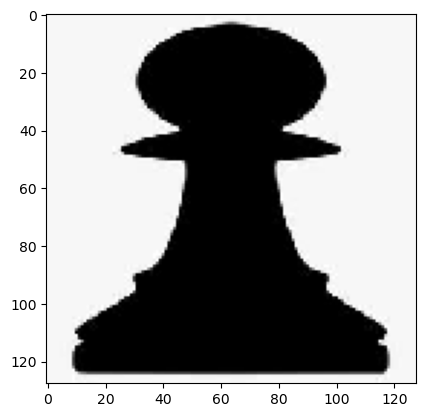

1/1 [==============================] - 0s 279ms/step
Prediction labels:  [[0. 0. 1. 0. 0.]] 

Knight


In [9]:
img = image.load_img('/kaggle/input/chess-pieces-detection-images-dataset/pawn_resized/00000041_resized.jpg', target_size=(128, 128))

plt.imshow(img)
plt.show()

def rgb2gray(imgs, axs):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    
    return np.expand_dims(np.dot(imgs, rgb_weights), axis=axs)

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = rgb2gray(img, 3)

img_pred = model.predict(img)
print('Prediction labels: ', img_pred, '\n')

img_pred_value = np.where(img_pred == np.amax(img_pred))

if img_pred_value[1] == 0:
    print('Rook')
elif img_pred_value[1] == 1:
    print('Pawn')
elif img_pred_value[1] == 2:
    print('Knight')
elif img_pred_value[1] == 3:
    print('Queen')
else:
    print('Bishop')

In [10]:
metrics_df = pd.DataFrame(history.history)

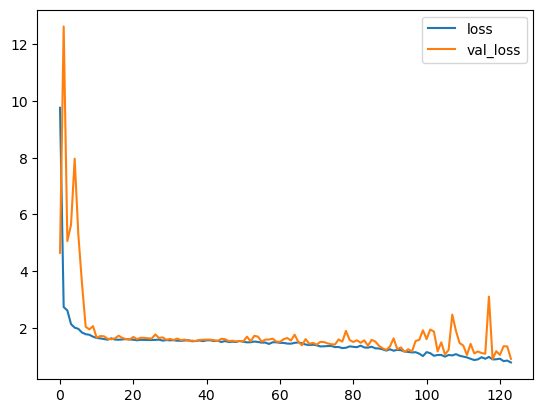

In [11]:
metrics_df[['loss', 'val_loss']].plot()
metrics_df[['accuracy', 'val_accuracy']].plot
plt.show()

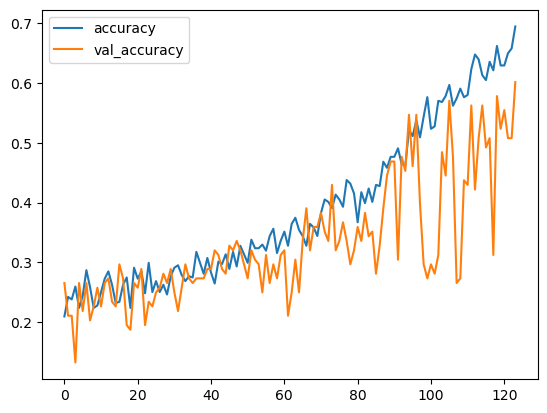

In [12]:
metrics_df[['accuracy', 'val_accuracy']].plot()
plt.show()